<a href="https://colab.research.google.com/github/ShuriKimura0402/project-examples/blob/main/ASR_practice2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


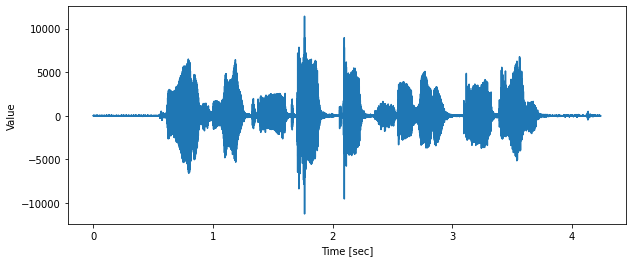

In [ ]:
#私の肉声を視覚的に表現してみる
#I try to express my voice visually

import wave
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('drive')

wav_file = wave.open("/content/drive/MyDrive/private/Alarm.wav" , "r" )  
out_plot = './plot.png'

with wave.open("/content/drive/MyDrive/private/Alarm.wav", "r") as wav:
    sampling_frequency = wav.getframerate()
    sample_size = wav.getsampwidth()
    num_channels = wav.getnchannels()
    num_samples = wav.getnframes()
    waveform = wav.readframes(num_samples)
    waveform = np.frombuffer(waveform, dtype=np.int16)

time_axis = np.arange(num_samples) / sampling_frequency
plt.figure(figsize=(10,4))
plt.plot(time_axis, waveform)

plt.xlabel("Time [sec]")
plt.ylabel("Value")
plt.savefig(out_plot)

Mounted at drive


Exception ignored in: <function Wave_read.__del__ at 0x7f4e91f28710>
Traceback (most recent call last):
  File "/usr/lib/python3.7/wave.py", line 171, in __del__
  File "/usr/lib/python3.7/wave.py", line 194, in close
OSError: [Errno 107] Transport endpoint is not connected


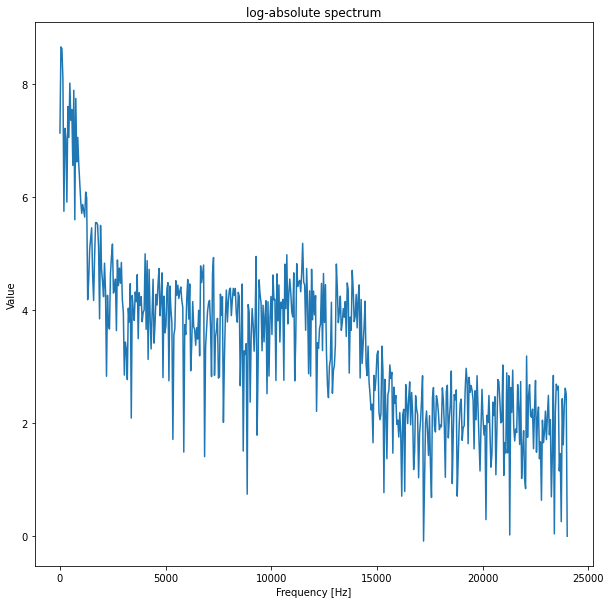

In [ ]:
#目的：音声認識のための特徴量抽出について考える。このために、フーリエ変換をする。対数振幅スペクトルによって、極端な値の揺れを減らす。
#Objective: Consider feature extraction for speech recognition. 
#For this purpose, a Fourier transform is performed. The logarithmic amplitude spectrum reduces extreme value fluctuations.

import wave
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('drive', force_remount=True)

wav_file = wave.open("/content/drive/MyDrive/private/Alarm.wav" , "r" )  
buf = wav_file.readframes(wav_file.getnframes())
data = np.frombuffer(buf, dtype="int16")

target_time = 0.5
fft_size = 1024
out_plot = './spectrum.png'

with wave.open("/content/drive/MyDrive/private/Alarm.wav", "r") as wav:
    sampling_frequency = wav.getframerate()
    waveform = wav.readframes(wav.getnframes())
    waveform = np.frombuffer(waveform, dtype=np.int16)

target_index = np.int(target_time * sampling_frequency)
frame = waveform[target_index: target_index + fft_size]

spectrum = np.fft.fft(frame)
absolute = np.abs(spectrum)
absolute = absolute[:np.int(fft_size/2) + 1]
log_absolute = np.log(absolute + 1E-7)

plt.figure(figsize=(10,10))
freq_axis = np.arange(np.int(fft_size/2)+1) \
            * sampling_frequency / fft_size
plt.plot(freq_axis, log_absolute)
plt.title('log-absolute spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Value')


plt.savefig(out_plot)

Mounted at drive


Exception ignored in: <function Wave_read.__del__ at 0x7f4e91f28710>
Traceback (most recent call last):
  File "/usr/lib/python3.7/wave.py", line 171, in __del__
  File "/usr/lib/python3.7/wave.py", line 194, in close
OSError: [Errno 107] Transport endpoint is not connected


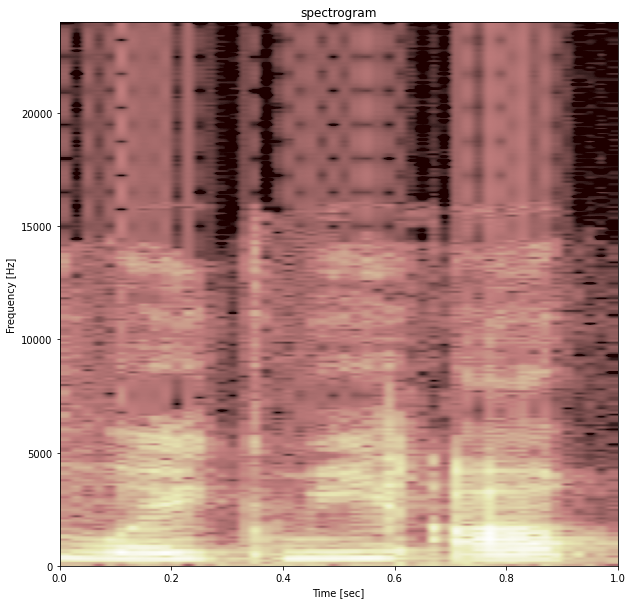

In [ ]:
#目的：時間変化の情報がわかるようにするため、短い時間ごとに音声を区切る。短時間フーリエ変換してスペクトログラムを作る。ハミング窓を使う。
#Purpose: Separate the audio at short time intervals so that information on time changes can be understood. 
#Short-time Fourier transform is performed to create a spectrogram. Use humming windows.

import wave
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('drive', force_remount=True)

wav_file = wave.open("/content/drive/MyDrive/private/Alarm.wav" , "r" )
frame_size = 10
frame_shift = 20

out_plot = './spectrogram.png'

with wave.open("/content/drive/MyDrive/private/Alarm.wav", "r") as wav:
    sample_frequency = wav.getframerate()
    num_samples = wav.getframerate()
    waveform = wav.readframes(num_samples)
    waveform = wav.readframes(num_samples)
    waveform = np.frombuffer(waveform, dtype=np.int16)

frame_size = int(sample_frequency \
                 * frame_size * 0.001)

frame_shift = int(sample_frequency * frame_shift * 0.001)

fft_size = 1
while fft_size < frame_size:
    fft_size *= 2

num_frames = (num_samples - frame_size) // frame_shift + 1
spectrogram = np.zeros((num_frames, int(fft_size/2)+1))

for frame_idx in range(num_frames):
    start_index = frame_idx * frame_shift
    frame = waveform[start_index : \
                     start_index + frame_size].copy()
    
    frame = frame * np.hamming(frame_size)
    spectrum = np.fft.fft(frame, n=fft_size)
    absolute = np.abs(spectrum)
    absolute = absolute[:int(fft_size/2) + 1]
    log_absolute = np.log(absolute + 1E-7)
    spectrogram[frame_idx, :] = log_absolute

plt.figure(figsize=(10,10))
spectrogram -= np.max(spectrogram)
vmax = np.abs(np.min(spectrogram)) * 0.0
vmin = -np.abs(np.min(spectrogram)) * 0.7

plt.imshow(spectrogram.T[-1::-1,:],
           extent=[0, num_samples / sample_frequency,
                   0, sample_frequency / 2],
           cmap = 'pink',
           vmax = vmax,
           vmin = vmin,
           aspect = 'auto')

plt.title('spectrogram')
plt.xlabel('Time [sec]')
plt.ylabel('Frequency [Hz]')

plt.savefig(out_plot)


Mounted at drive


Exception ignored in: <function Wave_read.__del__ at 0x7f4e91f28710>
Traceback (most recent call last):
  File "/usr/lib/python3.7/wave.py", line 171, in __del__
  File "/usr/lib/python3.7/wave.py", line 194, in close
OSError: [Errno 107] Transport endpoint is not connected


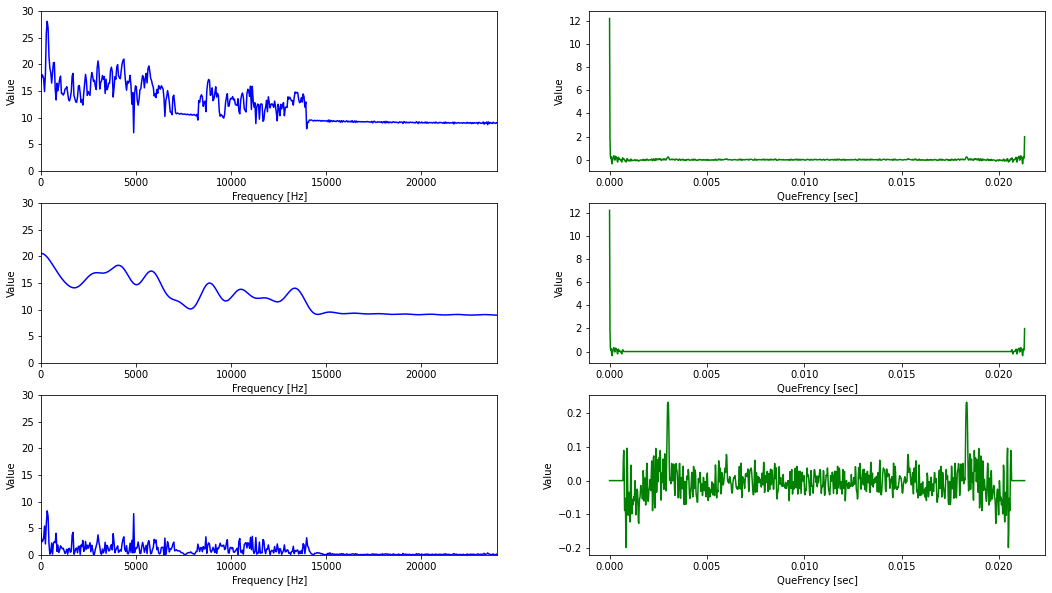

In [ ]:
#ケプストラム分析を行う。左側（青）が対数パワースペクトルで、右側(緑)がケプストラムを表示している。
#Perform cepstrum analysis. The left side (blue) shows the logarithmic power spectrum, and the right side (green) shows the cepstrum.

import wave
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('drive', force_remount=True)

wav_file = wave.open("/content/drive/MyDrive/private/Alarm.wav" , "r" )

target_time = 0.58
target_time = 0.73

fft_size = 1024
cep_threshold = 33
out_plot = './cepstrum.png'

with wave.open("/content/drive/MyDrive/private/Alarm.wav", "r") as wav:
    sampling_frequency = wav.getframerate()
    waveform = wav.readframes(wav.getnframes())
    waveform = np.frombuffer(waveform, dtype=np.int16)

target_index = np.int(target_time * sampling_frequency)

frame = waveform[target_index:
                 target_index + fft_size].copy()

frame = frame * np.hamming(fft_size)
spectrum = np.fft.fft(frame)
log_power = 2 * np.log(np.abs(spectrum) + 1E-7)

cepstrum = np.fft.ifft(log_power)

cepstrum_low = cepstrum.copy()
cepstrum_low[(cep_threshold+1):-(cep_threshold)] = 0.0

log_power_ceplo = np.abs(np.fft.fft(cepstrum_low))

cepstrum_high = cepstrum - cepstrum_low
log_power_cephi = np.abs(np.fft.fft(cepstrum_high))

plt.figure(figsize=(18,10))

freq_axis = np.arange(fft_size) \
            * sampling_frequency / fft_size

for n, log_pow in enumerate([log_power,
                             log_power_ceplo ,
                             log_power_cephi]):
    plt.subplot(3, 2, n*2+1)
    plt.plot(freq_axis, log_pow, color='b')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Value')
    plt.xlim([0, sampling_frequency / 2])
    plt.ylim([0, 30])

qefr_axis = np.arange(fft_size) / sampling_frequency

for n, cepst in enumerate([cepstrum,
                           cepstrum_low ,
                           cepstrum_high]):
    plt.subplot(3, 2, n*2+2)
    plt.plot(qefr_axis, np.real(cepst), color='g')
    plt.xlabel('QueFrency [sec]')
    plt.ylabel('Value')

plt.savefig(out_plot)

In [ ]:
!pip install librosa
!pip install scipy

In [ ]:
#Get MFCC by using librosa

import librosa
import soundfile as sf
x, fs = sf.read('/content/drive/MyDrive/private/hello.wav')
mfccs = librosa.feature.mfcc(x, sr=fs)
print(mfccs.shape)
print(mfccs[0])

(20, 466)
[-564.61276187 -560.86489091 -558.68224533 -557.87918526 -556.31243326
 -563.13479133 -570.18902728 -568.57491026 -565.9455744  -565.19880692
 -568.48897119 -567.28207875 -563.87475178 -557.76240587 -562.02871849
 -571.39619635 -576.07810336 -566.25079339 -558.3266995  -561.05870139
 -563.76497167 -570.74485315 -571.70394986 -568.81015319 -573.44869074
 -571.05984842 -571.17554067 -567.36056778 -566.51387112 -567.73787029
 -563.7040974  -558.04628164 -559.24758072 -559.76650652 -564.58604053
 -569.09156147 -568.13399171 -570.04720621 -572.16620418 -572.62548428
 -571.18307294 -569.61903539 -572.29516937 -553.57075209 -502.86578982
 -494.71240756 -524.2097224  -537.20246797 -544.65759344 -548.77991286
 -547.07957926 -547.75107067 -551.75605187 -548.59604332 -546.88085392
 -547.94523699 -549.97706454 -549.26174414 -553.71866286 -557.85572245
 -566.23012264 -561.88401505 -558.02564241 -565.75246595 -562.51982316
 -559.44263604 -562.55198132 -569.07250915 -568.03060357 -565.47770

In [ ]:
#Scipyで自分の音声の情報を表示する
import scipy
import numpy as np
import librosa
from scipy.io import wavfile 

sr, wav = wavfile.read('/content/drive/MyDrive/private/Alarm.wav')
sr

48000

In [ ]:
wav.shape

(203448,)

In [ ]:
len(wav) / sr

4.2385

In [ ]:
wav

array([  0,   0,   0, ..., -29, -30, -30], dtype=int16)

In [ ]:
type(wav)

numpy.ndarray

Text(0, 0.5, 'Amplitude')

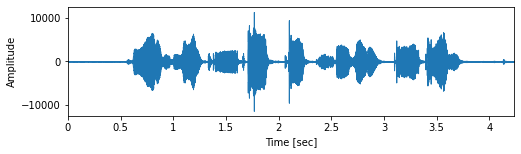

In [ ]:
#Scipyを使って自分の音声を可視化
import scipy
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.io import wavfile 

sr, x = wavfile.read('/content/drive/MyDrive/private/Alarm.wav')
fig, ax = plt.subplots(figsize=(8,2))
librosa.display.waveplot(x.astype(np.float32), sr, ax=ax)

ax.set_xlabel("Time [sec]")
ax.set_ylabel("Amplitude")
